In [1]:
from notebook_importer import *
import Commons
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm

importing notebook from Commons.ipynb


In [2]:
import json
import requests
from datetime import datetime, timedelta

j = requests.get('http://simon.lacnic.net/static/results-lac-connectivity.json').text

rs = json.loads(j)

since = datetime(year=2016, month=7, day=1)
rs_speed = [
    r for r in rs
    if datetime.strptime(r['date_probe'][:-6], '%Y-%m-%d %H:%M:%S.%f') >= since
]

In [3]:
since = datetime(year=2015, month=1, day=1)
until = datetime(year=2015, month=11, day=30)

rs_speed_2015 = [
    r for r in rs
    if datetime.strptime(r['date_probe'][:-6], '%Y-%m-%d %H:%M:%S.%f') >= since
    and datetime.strptime(r['date_probe'][:-6], '%Y-%m-%d %H:%M:%S.%f') <= until
]

In [4]:
since = datetime(year=2020, month=1, day=1)
rs_speed_2020 = [
    r for r in rs
    if datetime.strptime(r['date_probe'][:-6], '%Y-%m-%d %H:%M:%S.%f') >= since
]

In [5]:
len(rs_speed_2020)

2135

In [6]:
_from = datetime(year=2016, month=1, day=1)
to = datetime(year=2016, month=12, day=31)
rs_speed_2016 = [
    r for r in rs
    if datetime.strptime(r['date_probe'][:-6], '%Y-%m-%d %H:%M:%S.%f') >= _from and
    datetime.strptime(r['date_probe'][:-6], '%Y-%m-%d %H:%M:%S.%f') <= to
]

In [7]:
_from = datetime(year=2017, month=1, day=1)
to = datetime(year=2017, month=12, day=31)
rs_speed_2017 = [
    r for r in rs
    if datetime.strptime(r['date_probe'][:-6], '%Y-%m-%d %H:%M:%S.%f') >= _from and
    datetime.strptime(r['date_probe'][:-6], '%Y-%m-%d %H:%M:%S.%f') <= to
]

In [8]:
rs_speed_historic = [
    r for r in rs
]

In [9]:
len(rs_speed_2016)

338181

In [10]:
from sys import stdout
from numpy import mean, median

def update_progress(progress):
    stdout.write("\rBuilding dict %.2f%%" % (1.0 * progress))
    stdout.flush()
    
def build_dict(results, ccs, dataset='speedchecker'):
    """
        dataset: speedchecker|atlas
    """
    
    if dataset == "speedchecker":
        cc_origin_key = 'country_origin'
        cc_destination_key = 'country_destination'
        rtt_key = 'min_rtt'
    elif dataset == "atlas":
        cc_origin_key = 'src_cc'
        cc_destination_key = 'dst_cc'
        rtt_key = 'min'
    else:
        return

    N = len(ccs)
    region_dict = defaultdict(None)
    for i, cc_o in enumerate(ccs):
        
        update_progress(100.0*i / N)
        
        rs = [r for r in results if r[cc_origin_key] == cc_o]

        if len(rs) == 0:
            continue

        cc_dict = defaultdict(None)
        for cc_d in ccs:
            rtts = [r[rtt_key] for r in rs if r[cc_destination_key] == cc_d]
            if len(rtts) > 0:
                rtt = mean(rtts)
                cc_dict[cc_d] = rtt
        region_dict[cc_o] = cc_dict
    update_progress(100.0)
    return region_dict

from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from datetime import datetime
from collections import defaultdict
import sys

def cluster_sort(key):
        INVALID = 10
        d = {'BF': 0, 'DJ': 1, 'BI': 2, 'BJ': 3, 'BW': 2, 'DZ': 1, 'ET': 1, 'YT': 1, 'RW': 2, 'TZ': 2, 'CM': 0, 'NA': 2, 'CD': 0, 'NE': 2, 'NG': 0, 'TN': 1, 'RE': 1, 'LR': 0, 'LS': 2, 'TG': 3, 'TD': 1, 'LY': 1, 'ZM': 2, 'CI': 1, 'GQ': 1, 'EG': 1, 'SL': 0, 'CG': 0, 'CF': 1, 'AO': 1, 'ZA': 2, 'GA': 1, 'GN': 0, 'GM': 0, 'ZW': 2, 'CV': 1, 'GH': 0, 'SZ': 2, 'MG': 1, 'MA': 1, 'KE': 2, 'ML': 1, 'KM': 0, 'ST': 0, 'MU': 2, 'MW': 2, 'SO': 1, 'SN': 1, 'MR': 0, 'SC': 1, 'UG': 2, 'MZ': 2, 'SD': 1}
        d = {'BF': 0, 'DJ': 1, 'BI': 2, 'BJ': 0, 'ZA': 2, 'BW': 3, 'DZ': 0, 'GN': 0, 'YT': 4, 'RW': 1, 'TZ': 2, 'GQ': 0, 'NA': 3, 'NE': 0, 'NG': 0, 'TN': 0, 'RE': 4, 'LR': 0, 'LS': 2, 'TG': 0, 'TD': 0, 'LY': 0, 'ZM': 3, 'CI': 0, 'CM': 0, 'EG': 0, 'CG': 0, 'CF': 0, 'AO': 0, 'CD': 0, 'GA': 0, 'ET': 0, 'GM': 0, 'ZW': 3, 'CV': 0, 'GH': 0, 'SZ': 2, 'MG': 0, 'MA': 0, 'KE': 2, 'ML': 0, 'KM': 0, 'ST': 2, 'MU': 2, 'MW': 2, 'SO': 1, 'SN': 0, 'SL': 0, 'SC': 0, 'UG': 2, 'MZ': 2, 'SD': 0}
        try:
            return d[key]
        except:
            return INVALID

def region_sort(key):
    return d_region[key]

import json

with open('restcountries.json') as f:
    restcountries = json.load(f)
    
def get_country_name(cc):
    for r in restcountries:
        if r['alpha2Code'] == cc:
            return r['name']
    return 'N/A'

def build_heatmap(
    dictionary, filename, plot_text=True, figsize=(12, 12), _max=400, _min=0, _ticks=10, banned=[], sort=None, title="", zero_colour=True, cmap=plt.cm.Blues, fontsize=8,
    yticklabels=None, xticklabels=None
):
    
#     if not DEBUG:
#         matplotlib.use('Agg')
    
#     build an empty matrix first
    origins = []
    destinations = []
    n = 0
    for o in sorted(dictionary):
        if o in banned: continue

        if o not in origins:
            origins.append(o)

        for d in sorted(dictionary[o]):
            if d in banned: continue

            if d not in destinations:
                destinations.append(d)

#     Apply sorting
    if sort != None:
        origins = sorted(origins, key=sort)
        destinations = sorted(destinations, key=sort)

    res = []
    n = 0
    N = len(origins) * len(destinations)
    for o in origins:
        for d in destinations:
            try:
                rtt = dictionary[o][d]
                if _max == 0 and _min == 0:  # unbounded
                    rtt = rtt
                elif _min < rtt < _max:
                    rtt = rtt
                else:
                    rtt = 0
            except:
                rtt = 0
            finally:
                res.append(rtt)
                    
                n += 1
                sys.stdout.write("\r Preparing Data (1/2) %.1f%%" % (100 * float(n / N)))
                sys.stdout.flush()

    print ""
    print "Painting matrix (2/2)"

    data = np.reshape(res, (len(origins), len(destinations)))
    fig, ax = plt.subplots(figsize=figsize, dpi=500)

    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    if zero_colour:
        cmaplist[0] = plt.cm.Greys(10)
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
        
    # define the bins and normalize
#     if _max and _min:
    bounds = np.linspace(_min, _max, _max+1)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    
    heatmap = ax.pcolor(data, cmap=cmap, norm=norm)
    
    if plot_text:
        for y in range(data.shape[0]):
            for x in range(data.shape[1]):
                plt.text(x + 0.5, y + 0.5, "%.0f" % data[y, x],
                         horizontalalignment='center',
                         verticalalignment='center',
                         fontsize=fontsize
                         )

    # put the major ticks at the middle of each cell
    plt.ylim(0, len(origins))
    plt.xlim(0, len(destinations))
    ax.set_xticks(np.arange(len(destinations)) + .5, minor=False)
    ax.set_yticks(np.arange(len(origins)) + .5, minor=False)

    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    if xticklabels:
        print ["%s" % xticklabels[d] for d in destinations]
        ax.set_xticklabels(["%s" % xticklabels[d] for d in destinations], minor=False, fontsize=fontsize)
    else:
        ax.set_xticklabels(destinations, minor=False, fontsize=fontsize)
        
    if yticklabels:
        ax.set_yticklabels(["%s" % yticklabels[o] for o in origins], minor=False, fontsize=fontsize)
    else:
        ax.set_yticklabels(["%s (%s)" % (get_country_name(o), o) for o in origins], minor=False, fontsize=fontsize)
    
    if not title:
        title = "Africa latency heatmap\n"
        if _max > 0: title += "Maxed at %d ms\n" % _max
        if banned != []:
            title += "Countries excluded:"
            for b in banned:
                title += " %s" % b.encode('utf-8')
            title += "\n"
        if sort == cluster_sort:
            title += "Sorted by latency cluster\n"
        elif sort == region_sort:
            title += "Sorted by geographical region\n"
        else:
            title += "Sorted by alphabetical order\n"
    
    plt.tight_layout()
    plt.title(title)
    
    plt.colorbar(
        heatmap,
        ticks=range(_min, int(_max)+_ticks, _ticks),
        boundaries=range(_min, int(_max)+_ticks, _ticks)
    )
    
    plt.savefig(filename + '.png', dpi=500, bbox_inches='tight')
    plt.savefig(filename + '.pdf', dpi=500, bbox_inches='tight')

    plt.show()

In [11]:
import networkx as nx

def build_graph(dictionary, inverse=False):
    G = nx.Graph()
    for d in dictionary:
        if d not in G.nodes(): G.add_node(d)
        for e in dictionary[d]:
            if e not in G.nodes(): G.add_node(e)
            weight = dictionary[d][e]
            if inverse: weight=weight
            else: weight=1.0/weight
            G.add_edge(d, e, weight=weight)
    return G

def clusterize(G):
    import matplotlib.pyplot as plt
    import community
    
    partition = community.best_partition(G)
    
#     print community.generate_dendrogram(G)
    
    #drawing
    pos = nx.spring_layout(G)
    pos=nx.drawing.nx_agraph.graphviz_layout(G)

    size = float(len(set(partition.values())))
    colors = range(int(size))
    plt.axis("off")
    for i, com in enumerate(set(partition.values())):
        list_nodes = [nodes for nodes in partition.keys()
                                    if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, with_labels=True, node_color="#81B3C1")

    nx.draw_networkx_edges(G, pos, width=.250)
    nx.draw_networkx_labels(G, pos, font_size=12)
#     nx.draw_networkx_edge_labels(G, pos, edge_labels={k: "%.0f"%v for k, v in nx.get_edge_attributes(G,'weight').iteritems()})
    plt.figure()
    print "Graph G modularity: %.5f" % community.modularity(partition, G)
    print "Graph G information:\n%s" % nx.info(G)
    
    G_i = community.induced_graph(partition=partition, graph=G)
    plt.axis("off")
    pos = nx.spring_layout(G_i, iterations=5)
    nx.draw_networkx_nodes(G_i, pos=pos, node_color="#81B3C1")
    nx.draw_networkx_edges(G_i, pos=pos)
    nx.draw_networkx_labels(G_i, pos=pos)
    plt.figure()
    
    print "Partition: %s" % partition
    return partition

In [12]:
import geoip2.database as geo

def get_cc_from_ip_address(ip_address):
    
    res = get_geo_info_from_ip_address(ip_address)
    if res is None:
        return 'XX'
    return res.country.iso_code

def get_geo_info_from_ip_address(ip_address):
    try:
        reader = geo.Reader("GeoLite2-City.mmdb")
        return reader.city(ip_address)
    except Exception as e:
        return None

In [13]:
import copy

def explode_states(ccs, _results):
    
    results = copy.deepcopy(_results)
    
    for rs in results:

        if rs['country_origin'] not in ccs and rs['country_destination'] not in ccs: continue  # do not edit this record
            
        for cc in ccs:
            if rs['country_origin'] in ccs:
                try:
                    subdivisions = get_geo_info_from_ip_address(rs['ip_origin']).subdivisions
                    if cc == rs['country_origin'] and subdivisions != ():
                        rs['country_origin'] = "%s.%s" % (cc, subdivisions[0].iso_code)
                except (AttributeError, KeyError, Exception) as e:
                    pass
                
            if rs['country_destination'] in ccs:
                try:
                    subdivisions = get_geo_info_from_ip_address(rs['ip_destination']).subdivisions
                    if cc == rs['country_destination'] and subdivisions != ():
                        rs['country_destination'] = "%s.%s" % (cc, subdivisions[0].iso_code)
                except (AttributeError, KeyError, Exception) as e:
                    pass
            
    return results

In [14]:
import json
from requests import get

def atlas_reader(url):
    
    response = json.loads(get(url).text)
    
    results = response['results']
    
    if response['next'] is not None:
        res = atlas_reader(response['next'])
        results += res
    return results

In [15]:
%matplotlib inline

from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
from matplotlib.patches import Polygon

def map(
    dictionary, filename, title="Latency map", Min=0, Max=225.0, Ticks=25, colorbar=plt.cm.magma_r,
    llcrnrlat=-40,urcrnrlat=40,
    llcrnrlon=-30,urcrnrlon=60,
    lat_ts=20,
    resolution='c',
    lines=[],
    linewidth=1.0,
    linecolor='b',linecolors=[],
    linealpha=1.0,
    show_colorbar=True
):
    
    m = Basemap(
        projection='merc',
        llcrnrlat=llcrnrlat,urcrnrlat=urcrnrlat,
        llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,
        lat_ts=lat_ts,
        resolution=resolution
    )
    
    for i, line in enumerate(lines):
        lat1=line[0][0]
        long1=line[0][1]
        lat2=line[1][0]
        long2=line[1][1]
        if linecolors != []:
            _linecolor = linecolors[i]
        else:
            _linecolor = linecolor
        m.drawgreatcircle(lat1,long1,lat2,long2,linewidth=linewidth,color=_linecolor,alpha=linealpha)
        
    states = {
        'BR': False,
        'AR': False
    }
    for k in dictionary.keys():
        if 'BR.' in k:
            states['BR'] = True
        elif 'AR.' in k:
            states['AR'] = True

    if states['BR']:
        m.readshapefile('BRA_adm1', name='states_br', drawbounds=True)
    if states['AR']:
        m.readshapefile('ARG_adm1', name='states_ar', drawbounds=True)
    m.readshapefile('world_borders', name='countries', drawbounds=True, default_encoding="latin1")
    
    ax = plt.gca()

    triples = [(m.countries_info, m.countries, ['ISO2'] * len(m.countries_info))]
    if states['BR']:
        triples.append((m.states_br_info, m.states_br, ['HASC_1'] * len(m.states_br)))
    if states['AR']:
        triples.append((m.states_ar_info, m.states_ar, ['HASC_1'] * len(m.states_ar)))
        
    for triple in triples:
        for country_info, country, key in zip(*triple):

            try:
                cc = country_info[key]
            except KeyError as e:
                print e
                continue
            
            if cc not in dictionary.keys(): continue
                
            fill = True
            hatch = None
            try:
                value = (float(dictionary[cc] - Min) / (Max - Min)) * 255.0
            except:
                hatch = '/'
                fill = False
                value = 0

            color = colorbar(int(value))
            poly = Polygon(country, facecolor=color, edgecolor=color, fill=fill, hatch=hatch)
            ax.add_patch(poly)

    if show_colorbar:
        cax = ax.imshow([dictionary.values()], interpolation='nearest', cmap=colorbar, vmax=Max, vmin=Min)
        plt.colorbar(
            cax,
            ticks=range(Min, int(Max)+Ticks, Ticks),
            boundaries=range(Min, int(Max)+Ticks, Ticks)
        )
    plt.title(title)
    plt.tight_layout()
    
    plt.savefig("figs/%s.png" % filename, dpi=300)
    plt.savefig("figs/%s.pdf" % filename)
#     plt.show()

In [16]:
# from collections import defaultdict

# m = Basemap()
# m.readshapefile('ARG_adm1', name='states_ar', drawbounds=True)


# states_names = defaultdict(str)
# for info in m.states_ar_info:
#     states_names[info['NAME_1'].replace('\xc3\xb3', 'o').replace('\xc3\xad', 'i').replace('\xc3\xa1', 'a').replace('\xc3\xa9', 'e')] = info['HASC_1']

# Probeapi

## Analizar qué tuplas de CC tienen demasiado pocas muestras

### Todos

In [17]:
cc_tuples = set([(r['country_origin'], r['country_destination']) for r in rs_speed])

In [18]:
count = []

for cc_o, cc_d in cc_tuples:
    c = len(
        [r['min_rtt'] for r in rs_speed if r['country_origin'] == cc_o and r['country_destination'] == cc_d]
    )
    count.append(c)
#     print cc_o, cc_d, c

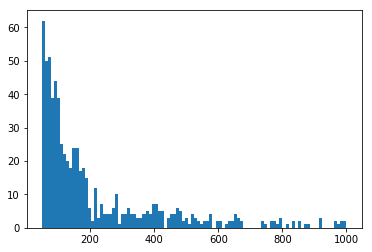

In [19]:
plt.hist(
    count,
    range=(50, 1E3),
    bins=100
)
plt.show()

In [20]:
LIMIT = 50

In [21]:

rs_speed_g100 = []
si = 0

for cc_o, cc_d in cc_tuples:
    rs = [r for r in rs_speed if r['country_origin'] == cc_o and r['country_destination'] == cc_d]
    
    if len(rs) >= LIMIT:
        si += 1
        rs_speed_g100 += rs

¿Qué % de tuplas perdemos?

In [22]:
print 100 - si*100.0/ len(cc_tuples)

46.2414578588


### 2016

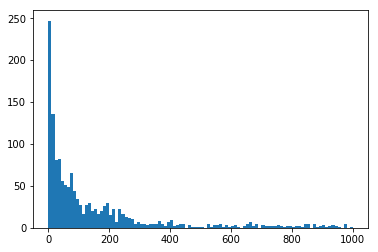

In [23]:
cc_tuples = set([(r['country_origin'], r['country_destination']) for r in rs_speed_2016])

count = []
for cc_o, cc_d in cc_tuples:
    c = len(
        [r['min_rtt'] for r in rs_speed_2016 if r['country_origin'] == cc_o and r['country_destination'] == cc_d]
    )
    count.append(c)
    
plt.hist(
    count,
    range=(0, 1E3),
    bins=100
)
plt.show()

In [24]:
rs_speed_2016_g100 = []

for cc_o, cc_d in cc_tuples:
    rs = [r for r in rs_speed_2016 if r['country_origin'] == cc_o and r['country_destination'] == cc_d]
    
    if len(rs) >= LIMIT:
        rs_speed_2016_g100 += rs

# Análisis de grafos

## Grafo (sin filtro)

In [25]:
import networkx as nx

Building dict 100.00%Graph G modularity: 0.10897
Graph G information:
Name: 
Type: Graph
Number of nodes: 42
Number of edges: 812
Average degree:  38.6667
Partition: {u'DO': 0, u'DM': 1, u'BB': 2, u'BO': 3, u'HT': 1, u'KN': 0, u'JM': 4, u'VC': 5, u'HN': 0, u'BR': 3, u'BS': 1, u'BZ': 1, u'PR': 1, u'NI': 0, u'LC': 0, u'TT': 5, u'PY': 3, u'VG': 1, u'PA': 2, u'PE': 3, u'TC': 0, u'GT': 0, u'CO': 4, u'VE': 4, u'AG': 1, u'CL': 3, u'AI': 4, u'VI': 6, u'EC': 7, u'GF': 2, u'AR': 3, u'GY': 1, u'AW': 2, u'CR': 0, u'GP': 2, u'CU': 3, u'UY': 3, u'SR': 4, u'SV': 2, u'MQ': 2, u'KY': 4, u'MX': 4}


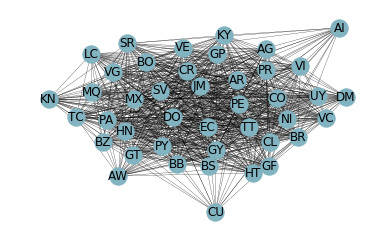

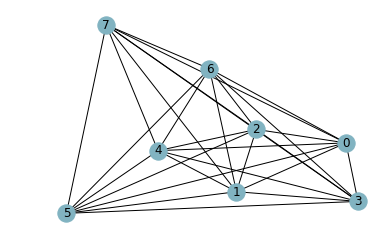

<Figure size 432x288 with 0 Axes>

In [26]:
ccs = [r['country_origin'] for r in rs_speed]
ccs += [r['country_destination'] for r in rs_speed]
ccs = list(set(ccs))

rs_dict = build_dict(rs_speed, ccs=ccs, dataset='speedchecker')
G = build_graph(rs_dict)
cluster_speed = clusterize(G)

## Grafo (con filtro g__100)

Building dict 100.00%Graph G modularity: 0.11728
Graph G information:
Name: 
Type: Graph
Number of nodes: 38
Number of edges: 492
Average degree:  25.8947
Partition: {u'DO': 0, u'BB': 1, u'BO': 2, u'HT': 3, u'KN': 3, u'JM': 1, u'VC': 0, u'HN': 0, u'BR': 3, u'BS': 0, u'BZ': 0, u'PR': 0, u'NI': 4, u'TT': 0, u'PY': 3, u'VG': 0, u'PA': 4, u'PE': 5, u'TC': 0, u'GT': 4, u'CO': 4, u'VE': 1, u'AG': 0, u'CL': 3, u'VI': 4, u'EC': 0, u'GF': 4, u'AR': 3, u'GY': 1, u'AW': 3, u'CR': 4, u'GP': 1, u'UY': 3, u'SR': 0, u'SV': 4, u'MQ': 1, u'KY': 4, u'MX': 1}


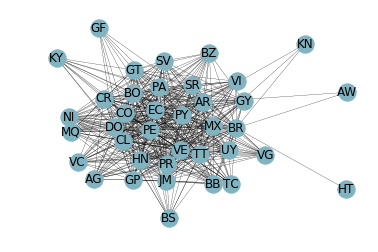

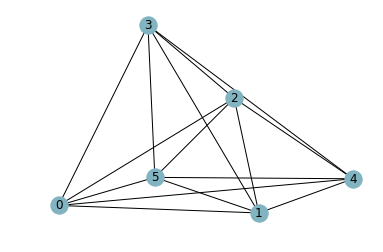

<Figure size 432x288 with 0 Axes>

In [27]:
ccs = [r['country_origin'] for r in rs_speed_g100]
ccs += [r['country_destination'] for r in rs_speed_g100]
ccs = list(set(ccs))

rs_dict_g100 = build_dict(rs_speed_g100, ccs=ccs, dataset='speedchecker')
G_g100 = build_graph(rs_dict_g100)
cluster_speed_g100 = clusterize(G_g100)

## Grafo (con filtro g__100 para 2016 únicamente)

Building dict 100.00%Graph G modularity: 0.12243
Graph G information:
Name: 
Type: Graph
Number of nodes: 40
Number of edges: 563
Average degree:  28.1500
Partition: {u'DO': 0, u'CL': 1, u'BB': 0, u'BO': 2, u'HT': 3, u'KN': 4, u'JM': 0, u'VC': 0, u'HN': 0, u'BR': 1, u'BS': 2, u'BZ': 3, u'PR': 0, u'NI': 3, u'LC': 2, u'TT': 0, u'PY': 1, u'PA': 0, u'PE': 5, u'TC': 0, u'GT': 3, u'CO': 2, u'VE': 3, u'AG': 0, u'VG': 0, u'VI': 0, u'EC': 2, u'GF': 3, u'AR': 1, u'GY': 3, u'AW': 1, u'CR': 0, u'GP': 3, u'CU': 3, u'UY': 1, u'SR': 0, u'SV': 3, u'MQ': 3, u'KY': 2, u'MX': 4}


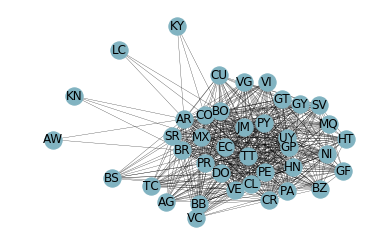

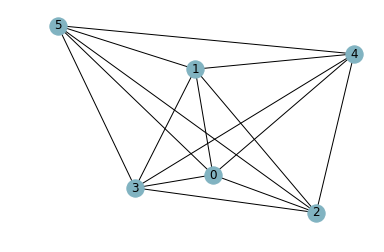

<Figure size 432x288 with 0 Axes>

In [28]:
ccs = [r['country_origin'] for r in rs_speed_2016_g100]
ccs += [r['country_destination'] for r in rs_speed_2016_g100]
ccs = list(set(ccs))

rs_dict_2016_g100 = build_dict(rs_speed_2016_g100, ccs=ccs, dataset='speedchecker')
G_2016_g100 = build_graph(rs_dict_2016_g100)
cluster_speed_2016_g100 = clusterize(G_2016_g100)

## 2020

Building dict 100.00%Graph G modularity: 0.41700
Graph G information:
Name: 
Type: Graph
Number of nodes: 29
Number of edges: 100
Average degree:   6.8966
Partition: {u'DO': 0, u'GT': 1, u'CO': 3, u'VE': 1, u'CL': 2, u'BO': 1, u'HT': 2, u'JM': 1, u'AR': 2, u'HN': 0, u'EC': 0, u'BR': 1, u'BS': 1, u'CR': 0, u'BZ': 0, u'PR': 1, u'NI': 0, u'GF': 0, u'SR': 1, u'TT': 1, u'GP': 1, u'GY': 2, u'SV': 3, u'PA': 0, u'MQ': 1, u'PY': 1, u'CU': 2, u'PE': 2, u'MX': 1}


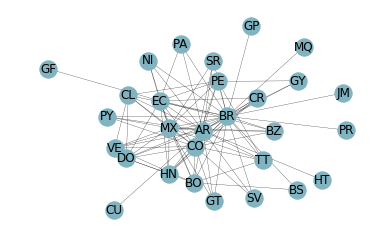

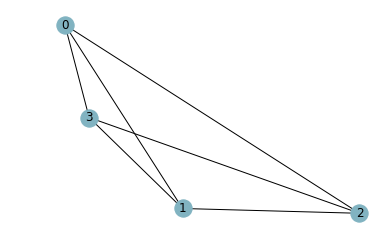

<Figure size 432x288 with 0 Axes>

In [29]:
ccs = [r['country_origin'] for r in rs_speed_2020]
ccs += [r['country_destination'] for r in rs_speed_2020]
ccs = list(set(ccs))

rs_speed_2020_g = build_dict(rs_speed_2020, ccs=ccs, dataset='speedchecker')
G_2020_g = build_graph(rs_speed_2020_g)
cluster_speed_2020 = clusterize(G_2020_g)

In [30]:
def clusters_to_ccs(clus_dict):
    """
        Prints clusters one by line
    """

    res = defaultdict(list)
    for cc, clus in clus_dict.iteritems():
        res[clus].append(cc.encode())
    for clus, ccs_list in res.iteritems():
        print clus, ccs_list

In [31]:
clusters_to_ccs(cluster_speed)  # prints
print 10*'-'
clusters_to_ccs(cluster_speed_g100)  # prints
print 10*'-'
clusters_to_ccs(cluster_speed_2016_g100)  # prints
print 10*'-'

clusters_to_ccs(cluster_speed_2020)  # prints

0 ['DO', 'KN', 'HN', 'NI', 'LC', 'TC', 'GT', 'CR']
1 ['DM', 'HT', 'BS', 'BZ', 'PR', 'VG', 'AG', 'GY']
2 ['BB', 'PA', 'GF', 'AW', 'GP', 'SV', 'MQ']
3 ['BO', 'BR', 'PY', 'PE', 'CL', 'AR', 'CU', 'UY']
4 ['JM', 'CO', 'VE', 'AI', 'SR', 'KY', 'MX']
5 ['VC', 'TT']
6 ['VI']
7 ['EC']
----------
0 ['DO', 'VC', 'HN', 'BS', 'BZ', 'PR', 'TT', 'VG', 'TC', 'AG', 'EC', 'SR']
1 ['BB', 'JM', 'VE', 'GY', 'GP', 'MQ', 'MX']
2 ['BO']
3 ['HT', 'KN', 'BR', 'PY', 'CL', 'AR', 'AW', 'UY']
4 ['NI', 'PA', 'GT', 'CO', 'VI', 'GF', 'CR', 'SV', 'KY']
5 ['PE']
----------
0 ['DO', 'BB', 'JM', 'VC', 'HN', 'PR', 'TT', 'PA', 'TC', 'AG', 'VG', 'VI', 'CR', 'SR']
1 ['CL', 'BR', 'PY', 'AR', 'AW', 'UY']
2 ['BO', 'BS', 'LC', 'CO', 'EC', 'KY']
3 ['HT', 'BZ', 'NI', 'GT', 'VE', 'GF', 'GY', 'GP', 'CU', 'SV', 'MQ']
4 ['KN', 'MX']
5 ['PE']
----------
0 ['DO', 'HN', 'EC', 'CR', 'BZ', 'NI', 'GF', 'PA']
1 ['GT', 'VE', 'BO', 'JM', 'BR', 'BS', 'PR', 'SR', 'TT', 'GP', 'MQ', 'PY', 'MX']
2 ['CL', 'HT', 'AR', 'GY', 'CU', 'PE']
3 ['CO', 'SV']


In [32]:
rtts = []

for cc,targets in rs_dict_g100.iteritems():
    for target_cc, rtt in targets.iteritems():
        rtts.append(rtt)
#         print cc, target_cc, rtt

In [33]:
import numpy as np

print np.median(rtts), 100.0*len([r for r in rtts if r < 300]) / len(rtts), 100.0*len([r for r in rtts if r < 400]) / len(rtts)

154.24404547094912 99.8587570621 100.0


In [34]:
from collections import defaultdict

rtts_self = defaultdict(list)
rtts_others= defaultdict(list)

for cc,targets in rs_dict_g100.iteritems():
    for target_cc, rtt in targets.iteritems():
        
        if target_cc == cc:
            rtts_self[cc].append(rtt)
        else:
            rtts_others[cc].append(rtt)
            rtts_others[target_cc].append(rtt)

## Relación intra-país / inter-país

In [35]:
ratios = []

for cc in rtts_self.keys():
    ratio = np.median(rtts_self[cc]) / np.median(rtts_others[cc])
    ratios.append(ratio)
    
    if ratio > 1.0:
        print cc, ratio
#     print ratio, cc, rtts_self[cc], np.median(rtts_others[cc])

In [36]:
np.mean(ratios)

0.45923559767972194

In [37]:
np.mean([item for sublist in rtts_self.values() for item in sublist])

68.89872321346314

In [38]:
np.mean([item for sublist in rtts_others.values() for item in sublist])

163.31355434042763

## Comparación 2016 / 2017

## How many ASes are from LACNIC?

In [39]:
delegated_extended = requests.get('http://ftp.lacnic.net/pub/stats/lacnic/delegated-lacnic-extended-latest').text

In [40]:
lacnic_asns = []

for row in tqdm(delegated_extended.splitlines()):
    cols = row.split('|')
    kind = cols[2]
    if kind != 'asn':
        continue
    
    if 'allocated' not in row:
        continue
    
    asn = cols[3]
    lacnic_asns.append(int(asn))
   
asns_2016 = set([r['as_origin'] for r in rs_speed_2016 if r['as_origin'] in lacnic_asns])
asns_2017 = set([r['as_origin'] for r in rs_speed_2017 if r['as_origin'] in lacnic_asns])
asns_2020 = set([r['as_origin'] for r in rs_speed_2020 if r['as_origin'] in lacnic_asns])

100%|██████████| 77037/77037 [00:00<00:00, 498173.15it/s]


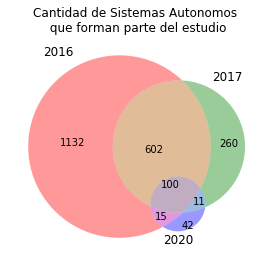

In [41]:
from matplotlib_venn import venn3

venn3(
    [
        asns_2016,
        asns_2017,
        asns_2020
    ],
    set_labels=['2016', '2017', '2020']
)
plt.title('Cantidad de Sistemas Autonomos \n que forman parte del estudio')
plt.show()

## Intersección AS Destination

In [42]:
in_common_2016_2017_tuples = set([(r['as_origin'], r['as_destination']) for r in rs_speed_2016 if r['as_origin'] in lacnic_asns and r['as_destination'] in lacnic_asns]
                         ).intersection(
                        set([(r['as_origin'], r['as_destination']) for r in rs_speed_2017 if r['as_origin'] in lacnic_asns and r['as_destination'] in lacnic_asns])
                                       )

In [43]:
len(in_common_2016_2017_tuples)

2358

ASes individuales

In [44]:
len(set([a[0] for a in in_common_2016_2017_tuples]).union(set([a[1] for a in in_common_2016_2017_tuples])))

319

36.0 183.0 35.0 164.0


/Users/aformoso/Dropbox/LACNIC/SIMON/papers/Notebook/IMC/venv2020/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


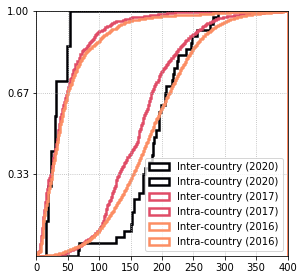

In [45]:
%matplotlib inline

rtts_speed_2016_intra = [r['min_rtt'] for r in rs_speed_2016 if r['country_origin'] == r['country_destination']
                         and (r['as_origin'], r['as_destination']) in in_common_2016_2017_tuples
                        ]
rtts_speed_2016_inter = [r['min_rtt'] for r in rs_speed_2016 if r['country_origin'] != r['country_destination']
                        and (r['as_origin'], r['as_destination']) in in_common_2016_2017_tuples
                        ]

rtts_speed_2017_intra = [r['min_rtt'] for r in rs_speed_2017 if r['country_origin'] == r['country_destination']
                        and (r['as_origin'], r['as_destination']) in in_common_2016_2017_tuples
                        ]
rtts_speed_2017_inter = [r['min_rtt'] for r in rs_speed_2017 if r['country_origin'] != r['country_destination']
                        and (r['as_origin'], r['as_destination']) in in_common_2016_2017_tuples
                        ]
rtts_speed_2020_intra = [r['min_rtt'] for r in rs_speed_2020 if r['country_origin'] == r['country_destination']
                        and (r['as_origin'], r['as_destination']) in in_common_2016_2017_tuples
                        ]
rtts_speed_2020_inter = [r['min_rtt'] for r in rs_speed_2020 if r['country_origin'] != r['country_destination']
                        and (r['as_origin'], r['as_destination']) in in_common_2016_2017_tuples
                        ]

plt.figure(figsize=(4.5,4.5))

print np.median(rtts_speed_2016_intra), np.median(rtts_speed_2016_inter), np.median(rtts_speed_2017_intra), np.median(rtts_speed_2017_inter)
    

plt.hist(
    [
        rtts_speed_2016_intra,
        rtts_speed_2016_inter,
        rtts_speed_2017_intra,
        rtts_speed_2017_inter,
        rtts_speed_2020_intra,
        rtts_speed_2020_inter
    ],
    range=(0,400),
    histtype='step',
    normed=True,
    cumulative=True,
    bins = 400,
    linewidth=2.5,
    label=[
        "Intra-country (2016)", "Inter-country (2016)",
        "Intra-country (2017)", "Inter-country (2017)",
        "Intra-country (2020)", "Inter-country (2020)",
    ],
    color=[
        plt.cm.magma_r(60), plt.cm.magma_r(60),
        plt.cm.magma_r(100), plt.cm.magma_r(100),
        plt.cm.magma_r(255), plt.cm.magma_r(255)
    ]
)
plt.yticks([1.0/3, 2.0/3, 1.0])
plt.gca().set_yticklabels(['{:.2f}'.format(x) for x in plt.gca().get_yticks()]) 

plt.grid(linestyle='dotted')
plt.margins(.0)
plt.legend(loc='lower right')
plt.savefig("figs/lac.pdf", dpi=500, bbox_inches='tight')
plt.savefig("figs/lac.png", dpi=500, bbox_inches='tight')
plt.show()

## 2017 únicamente

Building dict 100.00%Graph G modularity: 0.14339
Graph G information:
Name: 
Type: Graph
Number of nodes: 42
Number of edges: 514
Average degree:  24.4762
Partition: {u'DO': 0, u'DM': 1, u'BB': 2, u'BO': 0, u'HT': 1, u'SV': 2, u'JM': 1, u'VC': 1, u'HN': 2, u'BR': 1, u'BS': 2, u'BZ': 1, u'PR': 3, u'NI': 3, u'LC': 0, u'TT': 3, u'PY': 4, u'VG': 0, u'PA': 0, u'PE': 1, u'TC': 0, u'GT': 2, u'CO': 0, u'VE': 2, u'AG': 2, u'CL': 4, u'AI': 2, u'VI': 2, u'EC': 3, u'GF': 3, u'AR': 4, u'GY': 0, u'AW': 3, u'CR': 2, u'GP': 2, u'CU': 3, u'UY': 4, u'SR': 2, u'KN': 0, u'MQ': 0, u'KY': 2, u'MX': 1}


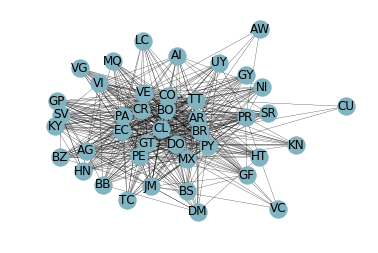

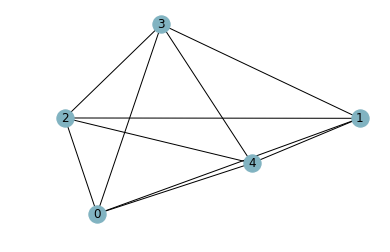

<Figure size 432x288 with 0 Axes>

In [84]:
ccs = set([r['country_origin'] for r in rs_speed_2017] + [r['country_destination'] for r in rs_speed_2017])

rs_dict = build_dict(rs_speed_2017, ccs=ccs, dataset='speedchecker')
G = build_graph(rs_dict)
cluster_speed_2017 = clusterize(G)

# Mapas

In [47]:
from collections import defaultdict
from numpy import median

def load_outgoing(dataset):
    outgoing = defaultdict(int)

    for o, D in dataset.iteritems():
        rtts = []
        for d, rtt in D.iteritems():
            if o == d:
                continue
            rtts.append(rtt)

        if len(rtts) == 0:
            continue

        outgoing[o] = median(rtts)
    return outgoing

def load_incoming(dataset):
    incoming = defaultdict(int)
    tmp = defaultdict(list)

    for o, D in dataset.iteritems():
        for d, rtt in D.iteritems():
            if o == d:
                continue
            tmp[d].append(rtt)

    for d, rtt_list in tmp.iteritems():
        incoming[d] = median(rtt_list)
        
    return incoming

Building dict 100.00%Graph G modularity: 0.14124
Graph G information:
Name: 
Type: Graph
Number of nodes: 42
Number of edges: 514
Average degree:  24.4762
Partition: {u'DO': 0, u'DM': 1, u'BB': 1, u'BO': 2, u'HT': 1, u'SV': 3, u'JM': 0, u'VC': 0, u'HN': 3, u'BR': 1, u'BS': 3, u'BZ': 4, u'PR': 2, u'NI': 2, u'LC': 4, u'TT': 1, u'PY': 5, u'VG': 4, u'PA': 4, u'PE': 1, u'TC': 4, u'GT': 4, u'CO': 4, u'VE': 3, u'AG': 3, u'CL': 5, u'AI': 0, u'VI': 1, u'EC': 3, u'GF': 2, u'AR': 5, u'GY': 1, u'AW': 1, u'CR': 4, u'GP': 3, u'CU': 1, u'UY': 5, u'SR': 0, u'KN': 4, u'MQ': 4, u'KY': 0, u'MX': 0}


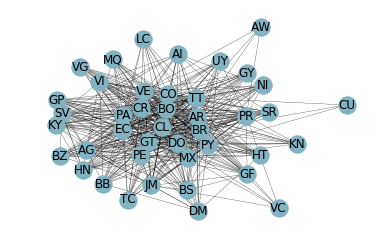

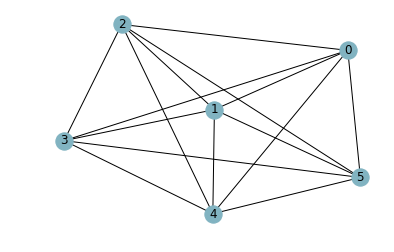

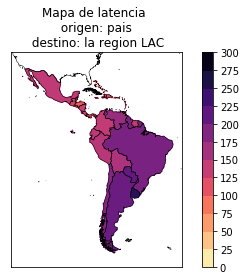

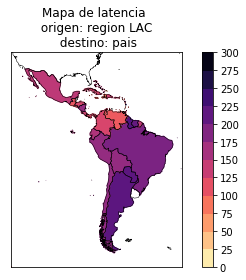

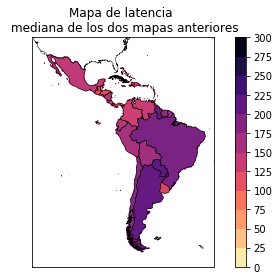

Building dict 100.00%Graph G modularity: 0.41437
Graph G information:
Name: 
Type: Graph
Number of nodes: 29
Number of edges: 100
Average degree:   6.8966
Partition: {u'DO': 0, u'GT': 1, u'CO': 3, u'VE': 1, u'CL': 2, u'BO': 1, u'HT': 2, u'JM': 1, u'AR': 2, u'HN': 0, u'EC': 0, u'BR': 1, u'BS': 1, u'CR': 0, u'BZ': 0, u'PR': 1, u'NI': 0, u'GF': 0, u'SR': 1, u'TT': 1, u'GP': 1, u'GY': 1, u'SV': 3, u'PA': 0, u'MQ': 1, u'PY': 1, u'CU': 2, u'PE': 1, u'MX': 1}


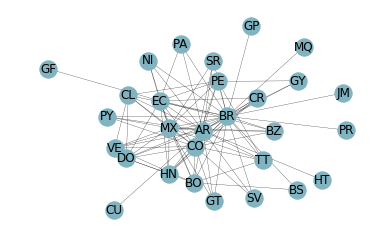

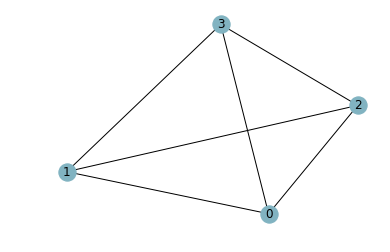

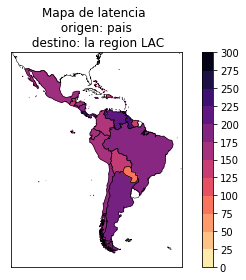

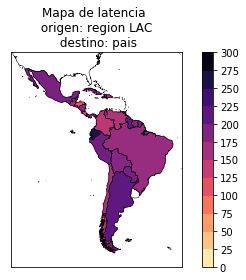

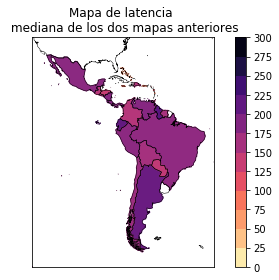

In [86]:
for dataset in [rs_speed_2017, rs_speed_2020]:
    
    ccs = set([r['country_origin'] for r in dataset] + [r['country_destination'] for r in dataset])
    rs_dict = build_dict(dataset, ccs=ccs, dataset='speedchecker')
    G = build_graph(rs_dict)
    cluster_speed_2017 = clusterize(G)

    outgoing = load_outgoing(rs_dict)
    incoming = load_incoming(rs_dict)
    
    map(
        outgoing,
        filename="lac_outgoing_speed",
        title="Mapa de latencia \n origen: pais \n destino: la region LAC",
        Max=300,
        Ticks=25,
        llcrnrlat=-60,urcrnrlat=40,
        llcrnrlon=-125,urcrnrlon=-30,
    )
    plt.show()
    
    map(
        incoming,
        filename="lac_incoming_speed",
        title="Mapa de latencia \n origen: region LAC \n destino: pais",
        Max=300,
        Ticks=25,
        llcrnrlat=-60,urcrnrlat=40,
        llcrnrlon=-125,urcrnrlon=-30,
    )
    plt.show()
    
    map(
        dict([(cc, np.median([rtt, incoming[cc]])) for (cc, rtt) in outgoing.iteritems()]),
        filename="lac_outgoing_incoming_speed",
        title="Mapa de latencia \n mediana de los dos mapas anteriores",
        Max=300,
        Ticks=25,
        llcrnrlat=-60,urcrnrlat=40,
        llcrnrlon=-125,urcrnrlon=-30,
    )
    plt.show()

In [54]:
cmap_colours = [
    'green',
    '#F40202',
    '#009DCA',
    '#FF9D00',
    'cyan',
    'tan',
    'grey',
    'magenta'
]

In [55]:
from collections import defaultdict

country_names = defaultdict(str)
for rest in restcountries:
    country_names[rest['alpha2Code']] = rest['name']

In [56]:
from collections import defaultdict

cluster_to_ccs = defaultdict(list)
for cc, clus in cluster_speed_g100.items():
    cluster_to_ccs[clus].append(cc)

for clus in set(cluster_speed_g100.values()):
    print clus, [country_names[c].encode('utf-8') for c in cluster_to_ccs[clus]]

0 ['Dominican Republic', 'Saint Vincent and the Grenadines', 'Honduras', 'The Bahamas', 'Belize', 'Puerto Rico', 'Trinidad and Tobago', 'Virgin Islands (British)', 'Turks and Caicos Islands', 'Antigua and Barbuda', 'Ecuador', 'Suriname']
1 ['Barbados', 'Jamaica', 'Venezuela', 'Guyana', 'Guadeloupe', 'Martinique', 'Mexico']
2 ['Bolivia']
3 ['Haiti', 'Saint Kitts and Nevis', 'Brazil', 'Paraguay', 'Chile', 'Argentina', 'Aruba', 'Uruguay']
4 ['Nicaragua', 'Panama', 'Guatemala', 'Colombia', 'Virgin Islands (U.S.)', 'French Guiana', 'Costa Rica', 'El Salvador', 'Cayman Islands']
5 ['Peru']


In [57]:
def rtts_between_clusters(results, clus1, clus2, bidirectional=True, key='min_rtt'):
    rtts = [
        r[key] for r in results if 
            r['country_origin'] in cluster_to_ccs[clus1] and r['country_destination'] in cluster_to_ccs[clus2]
    ]
    
    if bidirectional:
        rtts += rtts_between_clusters(results, clus2, clus1, bidirectional=False)
        
    return rtts

In [58]:
from collections import defaultdict
geolocs = defaultdict(list)
for rest in restcountries:
    geolocs[rest['alpha2Code']] = rest['latlng']

In [59]:
def compute_distance(la1, lo1, la2, lo2):
    from math import sin, cos, sqrt, atan2, radians

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(la1)
    lon1 = radians(lo1)
    lat2 = radians(la2)
    lon2 = radians(lo2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [60]:
from tqdm import tqdm

In [61]:
for rs in tqdm(rs_speed_g100 + rs_speed_2020):
    L = get_geo_info_from_ip_address(rs['ip_destination'])
    
    if L is None:
        rs['c_ratio'] = 101
        continue

    L = L.location
    lat2, lon2 = geolocs[rs['country_origin']]
    lat1, lon1 = [L.latitude, L.longitude]
                   
    try:
        kms = compute_distance(lat1, lon1, lat2, lon2)
    except TypeError:
        rs['c_ratio'] = 101
        continue
    
    ms = rs['min_rtt']
    
    mts = 1E3 * kms
    secs = 1.0 * ms / 1E3
    
    c = 3E8  # m/s
    
    c_ratio = 100.0 * (mts/secs) / (c/3)
    
    rs['c_ratio'] = c_ratio

100%|██████████| 186905/186905 [02:45<00:00, 1131.40it/s]


In [62]:
clusters_to_ccs(cluster_speed_g100)

0 ['DO', 'VC', 'HN', 'BS', 'BZ', 'PR', 'TT', 'VG', 'TC', 'AG', 'EC', 'SR']
1 ['BB', 'JM', 'VE', 'GY', 'GP', 'MQ', 'MX']
2 ['BO']
3 ['HT', 'KN', 'BR', 'PY', 'CL', 'AR', 'AW', 'UY']
4 ['NI', 'PA', 'GT', 'CO', 'VI', 'GF', 'CR', 'SV', 'KY']
5 ['PE']


In [66]:
verde = '#43AA8B'
rojo = '#F40202'
azul = '#009DCA'
anaranjado = '#FF9D00'
gris = '#B2B09B'
magenta = 'magenta'
negro = '#000000'

In [63]:
cluster_speed_g100_names = {
    0: 'Caribe + EC',
    1: 'Centro (MX)',
    2: 'Centro + C. Sur',
    3: 'Cono Sur'
}

In [67]:
# clus1 = 0
# clus2 = 0 

# for key in ['c_ratio', 'min_rtt']:
#     print key
#     for clus in set(cluster_speed_g100.values()):
#         rtts = rtts_between_clusters(rs_speed_g100, clus, clus, key=key)
#         plt.hist(
#                 rtts,
#                 range=(0,500),
#                 bins=500,
#                 normed=True,
#                 cumulative=True,
#                 histtype='step',
#                 label="Cluster #%d %s" % (clus, cluster_speed_g100_names[clus])
#             )
#         print clus, np.percentile(rtts, 50)

#     plt.legend(loc='lower right')
#     plt.margins(.0)
#     plt.grid(linestyle='dotted')

#     plt.show()

0 Dominican Republic, Saint Vincent and the Grenadines, Honduras, The Bahamas, Belize, Puerto Rico, Trinidad and Tobago, Virgin Islands (British), Turks and Caicos Islands, Antigua and Barbuda, Ecuador, Suriname
8249


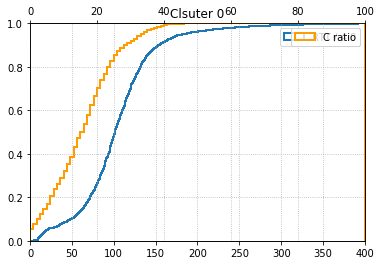

1 Barbados, Jamaica, Venezuela, Guyana, Guadeloupe, Martinique, Mexico
5985


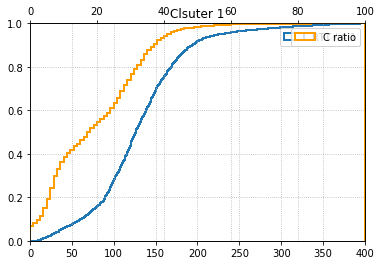

2 Bolivia
153


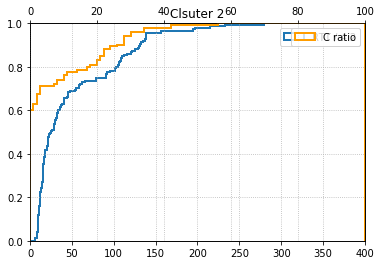

3 Haiti, Saint Kitts and Nevis, Brazil, Paraguay, Chile, Argentina, Aruba, Uruguay
18609


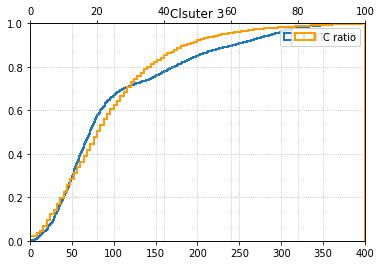

4 Nicaragua, Panama, Guatemala, Colombia, Virgin Islands (U.S.), French Guiana, Costa Rica, El Salvador, Cayman Islands
6761


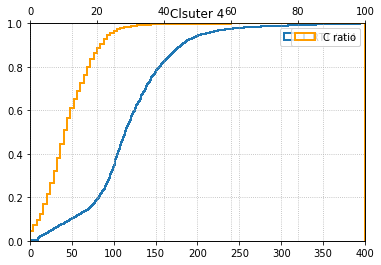

5 Peru
463


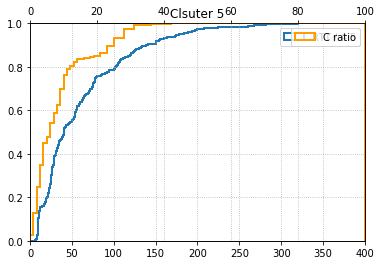

In [68]:
for clus in set(cluster_speed_g100.values()):

    rtts = [r['min_rtt'] for r in rs_speed_g100 if r['country_origin'] in cluster_to_ccs[clus] and r['country_destination'] in cluster_to_ccs[clus]]
    c_ratio = [r['c_ratio'] for r in rs_speed_g100 if r['country_origin'] in cluster_to_ccs[clus] and r['country_destination'] in cluster_to_ccs[clus]]

    plt.hist(
        rtts,
        range=(0,400),
        bins=400,
        normed=True,
        cumulative=True,
        histtype='step',
        linewidth=2.0,
        label="RTT / 4 %s" % clus
    )
    
    plt.legend()
    plt.margins(.0)
    plt.grid(linestyle='dotted')
    
    ax2 = plt.gca().twiny()
    
    ax2.hist(
        c_ratio,
        range=(0,100),
        bins=100,
        normed=True,
        cumulative=True,
        histtype='step',
        linewidth=2.0,
        label="C ratio",
        color=anaranjado
    )
    ax2.set_xlim(0,100)
    
    plt.title("Clsuter %d" % clus)
    
    print clus, ', '.join([country_names[cc].encode('utf-8') for cc in cluster_to_ccs[clus]])
    print len(rtts)

    
    
    ax2.legend()
    ax2.margins(.0)
    ax2.grid(linestyle='dotted')

    plt.show()

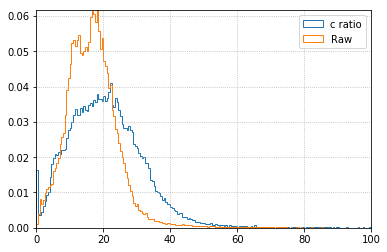

184770 184770


In [69]:
ratios = [r['c_ratio'] for r in rs_speed_g100]
latencies = [r['min_rtt']/10.0 for r in rs_speed_g100]

plt.hist(
    ratios,
    range=(0,100),
    bins=200,
    normed=True,
    histtype='step',
    label='c ratio'
)

plt.hist(
    latencies,
    range=(0,100),
    bins=200,
    normed=True,
    histtype='step',
    label='Raw'
)

plt.legend()
plt.grid(linestyle='dotted')
plt.margins(.0)

plt.show()

print len(ratios), len(latencies)

In [70]:
from matplotlib.colors import LinearSegmentedColormap

def map_lac_region(cluster, _cmap_colours=cmap_colours):
    
    cmap = LinearSegmentedColormap.from_list(
        'mycmap',
        [ (1.0*i/max(cluster.values()), color) for i,color in enumerate(_cmap_colours[:max(cluster.values())+1])]
    )

    map(
        cluster,
        filename="cluster_speed_lac",
        title="Map showing country clusters \n according to the Louvain clustering algorithm",
        Max=max(cluster.values()),
        Min=min(cluster.values()),
        Ticks=3,
        llcrnrlat=-60,urcrnrlat=40,
        llcrnrlon=-125,urcrnrlon=-30,
        colorbar=cmap,
        show_colorbar=False
    )
    plt.show()

    map(
        cluster,
        filename="cluster_speed_lac_central",
        title="Map showing country clusters \n according to the Louvain clustering algorithm",
        Max=max(cluster.values()),
        Min=min(cluster.values()),
        Ticks=3,
        llcrnrlat=0,urcrnrlat=40,
        llcrnrlon=-125,urcrnrlon=-40,
        colorbar=cmap,
        show_colorbar=False
    )
    plt.show()

    map(
        cluster,
        filename="cluster_speed_lac_caribbean",
        title="Map showing country clusters \n according to the Louvain clustering algorithm",
        Max=max(cluster.values()),
        Min=min(cluster.values()),
        Ticks=3,
        llcrnrlat=10,urcrnrlat=30,
        llcrnrlon=-90,urcrnrlon=-50,
        colorbar=cmap,
        show_colorbar=False
    )
    plt.show()

In [71]:
cmap_colours

['green', '#F40202', '#009DCA', '#FF9D00', 'cyan', 'tan', 'grey', 'magenta']

In [72]:
# print set(cluster_speed_2015.values())
print set(cluster_speed_2016_g100.values())
print set(cluster_speed_g100.values())

set([0, 1, 2, 3, 4, 5])
set([0, 1, 2, 3, 4, 5])


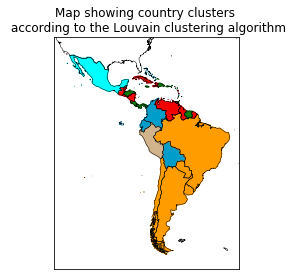

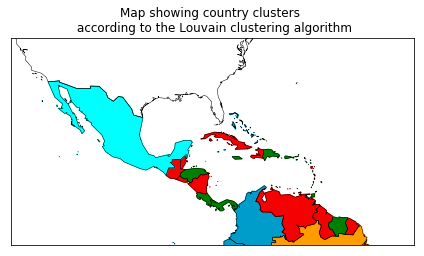

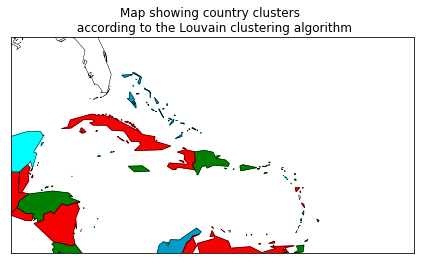

In [73]:
_cmap_colours = [
    'green',
    anaranjado,
    azul,
    rojo,
    'cyan',
    'tan',
    'grey',
    'magenta'
]

map_lac_region(
    cluster_speed_2016_g100,
    _cmap_colours=_cmap_colours
)

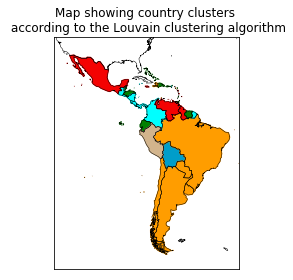

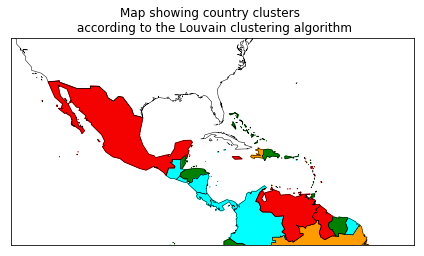

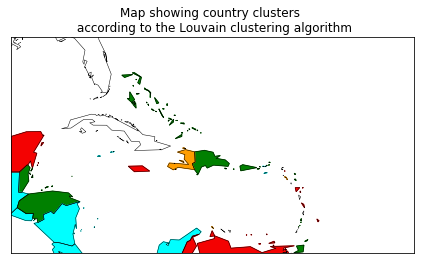

In [74]:
map_lac_region(cluster_speed_g100)  # 2017

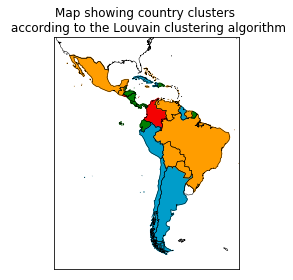

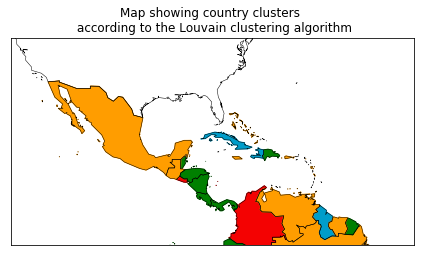

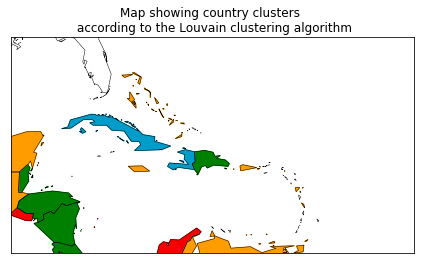

In [75]:
_cmap_colours = [
    'green',
    anaranjado,
    azul,
    rojo,
    'cyan',
    'tan',
    'grey',
    'magenta'
]

map_lac_region(
    cluster_speed_2020,
    _cmap_colours=_cmap_colours
)

In [76]:
from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np
import matplotlib

def cluster_matrix(results,
                   dataset, filename,
                   key='min_rtt',
                   title="Clusterized latency matrix",
                   names_x = [], names_y = [],
                   cmap=plt.cm.magma_r,
                   banned_countries=[],
                   banned_clusters=[],
                   Min=0, Max=800, Ticks=25
                  ):
    clusters_rtts = defaultdict(lambda: defaultdict(list))

    for rs in results:
        cc_o = rs['country_origin']
        cc_d = rs['country_destination']
        
        if cc_o in banned_countries or cc_d in banned_countries:
            continue
            
        clusters_rtts[dataset[cc_o]][dataset[cc_d]].append(rs[key])
        
    dim = max(dataset.values()) + 1 - len(banned_clusters)
    dims = (dim, dim)
    M = np.zeros(dims)

    i = 0
    for clus_o, D in clusters_rtts.iteritems():
        
        if clus_o in banned_clusters:
            continue
        
        j = 0
        for clus_d, rtt_list in D.iteritems():
            
            if clus_d in banned_clusters:
                continue
                
            M[i][j] = np.median(rtt_list)
            j += 1
        
        i += 1

    plt.figure(figsize=(3,3))
    plt.matshow(
        M,
        fignum=1,
        vmin = 0,
        vmax = Max,
        cmap=cmap
    )
    
    if names_x != []:
        plt.gca().set_xticklabels(
            [''] + names_x,
            minor=False,
            fontsize=8
        )
    if names_y != []:
        plt.gca().set_yticklabels(
            [''] + names_y,
            minor=False,
            fontsize=8
        )
        
    for y in range(M.shape[0]):
        for x in range(M.shape[1]):
            plt.text(
                x + 0.015, y + 0.015, "%.0f" % M[y, x],
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=8
            )
    
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
    bounds = np.linspace(Min, Max, Max+1)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
#     heatmap = plt.gca().pcolor(M, cmap=cmap, norm=norm)

    _range = range(Min, int(Max)+Ticks, Ticks)
    plt.colorbar(
#         heatmap,
        ticks=_range,
        boundaries=_range,
        fraction=0.045
    )
    
    plt.title(
        title,
        y=1.05
    )
    
    plt.savefig(
        "figs/%s.png" % filename,
        dpi=500,
        bbox_inches='tight'
    )
    plt.savefig(
        "figs/%s.pdf" % filename,
        dpi=500,
        bbox_inches='tight'
    )
    plt.show()

In [77]:
from collections import defaultdict

restcountries_names = {}
for rest in restcountries:
    cc = rest['alpha2Code']
    name = rest['name']
    restcountries_names[cc] = name

In [78]:
cluster_names = {
    'long': {
        0: 'Caribe 1 (HT)',
        1: 'Centro (MX)',
        2: '',
        3: 'Cono Sur',
    },
    'short': {
        0: '',
        1: 'MX',
        2: 'BO PE CO',
        3: 'C. Sur',
    }
}

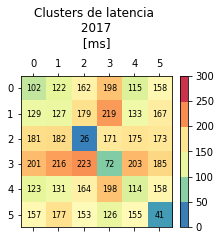

In [79]:
cluster_matrix(
    rs_speed_g100,
    cluster_speed_g100,
    filename="cluster-matrix-speed-lac-2017",
    title="Clusters de latencia \n 2017 \n [ms] \n",
#     names_y=cluster_names['long'].values(),
#     names_x=cluster_names['short'].values(),
    cmap=plt.get_cmap('Spectral_r'),
#     banned_countries=['VI'],
    Max=300,
    Ticks=50
)

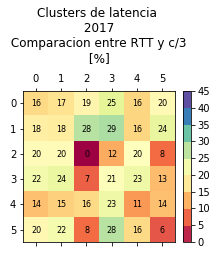

In [80]:
cluster_matrix(
    rs_speed_g100,
    cluster_speed_g100,
    key='c_ratio',
    filename="cluster-matrix-speed-lac-2017-c_comparison",
    title="Clusters de latencia \n 2017 \n Comparacion entre RTT y c/3 \n [%] \n",
#     names_y=[v for v in cluster_speed_no_vi.values()],
#     names_x = [v for v in cluster_speed_no_vi.values()],
    cmap=plt.get_cmap('Spectral'),
    Max=41,
    Ticks=5
)

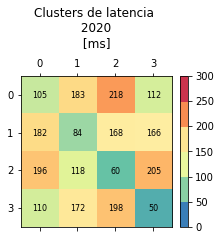

In [81]:
cluster_matrix(
    rs_speed_2020,
    cluster_speed_2020,
    filename="cluster-matrix-speed-lac-2020",
    title="Clusters de latencia \n 2020 \n [ms] \n",
    cmap=plt.get_cmap('Spectral_r'),
    Max=300,
    Ticks=50
)

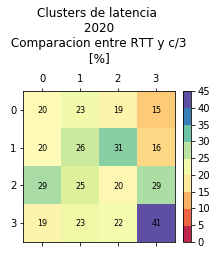

In [82]:
cluster_matrix(
    rs_speed_2020,
    cluster_speed_2020,
    key='c_ratio',
    filename="cluster-matrix-speed-lac-2020-c_comparison",
    title="Clusters de latencia \n 2020 \n Comparacion entre RTT y c/3 \n [%] \n",
#     names_y=[v for v in cluster_speed_no_vi.values()],
#     names_x = [v for v in cluster_speed_no_vi.values()],
    cmap=plt.get_cmap('Spectral'),
#     banned_countries=['VI'],
    Max=41,
    Ticks=5
)